In [4]:
import numpy as np
from hmmlearn import hmm
from itertools import product


In [5]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_hmm_transition_graph(T, niter=0,
                              highlight_node=-1, highlight_node_2=-1,
                              threshold=0.01, save=False, savename='img'):
    """
    Plot the HMM's transition matrix as a directed graph, using NetworkX.

    Parameters
    ----------
    T : 2D np.array of shape (N, N)
        Transition matrix (T[i,j] = P(z_{t+1}=j | z_t=i)).
    niter : int
        An iteration or epoch number (used in the figure title).
    highlight_node : int
        Index of a node to highlight in red (default: -1 = none).
    highlight_node_2 : int
        Index of a node to highlight in yellow (default: -1 = none).
    threshold : float
        Only plot edges with probability > threshold (to avoid clutter).
    save : bool
        Whether to save the figure to disk.
    savename : str
        Filename prefix for saving.

    Returns
    -------
    None
    """

    # Number of hidden states
    n_state = T.shape[0]

    # Initialize a directed graph
    G = nx.DiGraph()

    # Add nodes (one per hidden state)
    for s in range(n_state):
        G.add_node(s)

    # Edge-adding + edge labels
    edge_colors = []
    for s in range(n_state):
        for s_next in range(n_state):
            prob = T[s, s_next]
            if prob > threshold:  # filter out very small probabilities
                label = f"p={prob:.2f}"
                G.add_edge(s, s_next, label=label)
                # (optional) color all edges the same or by probability
                edge_colors.append("blue")

    # Layout for the nodes (you can use nx.circular_layout, nx.spring_layout, etc.)
    pos = nx.circular_layout(G)

    # Prepare figure
    plt.figure(figsize=(8, 6))

    # Node coloring
    colors = []
    for node in G.nodes():
        if node == highlight_node:
            colors.append("red")
        elif node == highlight_node_2:
            colors.append("yellow")
        else:
            colors.append("lightblue")

    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=1200)
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')

    # Draw edges
    edges = list(G.edges())
    nx.draw_networkx_edges(G, pos, edgelist=edges,
                           edge_color=edge_colors,
                           arrowstyle='->', arrowsize=20, width=2)

    # Edge labels
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=nx.get_edge_attributes(G, 'label'),
        font_size=10, label_pos=0.5
    )

    plt.axis('off')
    plt.title(f"HMM Transition Graph at iteration {niter}", size=16)
    plt.tight_layout()

    if save:
        plt.savefig(f"{savename}_iteration_{niter}.png", dpi=200)
        print(f"Saved figure to {savename}_iteration_{niter}.png")
    plt.show()


In [6]:

def create_nth_order_observations(sequence, n):
    """
    Convert a single sequence of discrete observations into an n-th order 'super-observation' sequence.
    
    E.g., if sequence = [2, 5, 5, 1] and n=2,
    we create pairs:
      (2, 5), (5, 5), (5, 1)
    Then we map each pair to a unique integer ID (so we can use it in a MultinomialHMM).
    
    Returns: 
      - X: a 1D numpy array of encoded observations 
    """
    if len(sequence) < n:
        return np.array([])  # not enough data to form even one super-observation
    
    # Create a sliding window of size n
    # Example: n=2 => [(seq[0], seq[1]), (seq[1], seq[2]), ...]
    windows = [tuple(sequence[i:i+n]) for i in range(len(sequence) - n + 1)]
    
    # We must map each unique window to a unique integer.
    # We'll do this globally below, so just return the list of tuples for now.
    return windows

def encode_super_observations(all_windows):
    """
    Given a list of lists of 'super-observations' (tuples),
    map each unique tuple to a unique integer code.
    
    Returns:
      - X_cat: a concatenated 1D numpy array of encoded observations
      - lengths: a list for each sequence length (required by hmmlearn for multiple sequences)
      - mapping_dict: the dictionary that maps each tuple to an integer ID
    """
    # Flatten all super-observation tuples across all sequences
    flattened = [obs for seq in all_windows for obs in seq]
    unique_obs = list(set(flattened))
    
    # Create a mapping from tuple -> integer
    mapping_dict = {obs_tuple: i for i, obs_tuple in enumerate(unique_obs)}
    
    # Encode each sequence
    encoded_sequences = []
    lengths = []
    for seq in all_windows:
        encoded_seq = [mapping_dict[tup] for tup in seq]
        encoded_sequences.append(encoded_seq)
        lengths.append(len(encoded_seq))
    
    # Concatenate into one big array (hmmlearn’s fit expects a 2D array of shape (n_samples, 1))
    X_cat = np.concatenate([np.array(es) for es in encoded_sequences])
    X_cat = X_cat.reshape(-1, 1)  # shape (total_length, 1)
    
    return X_cat, lengths, mapping_dict

def train_nth_order_hmm(
    sequences, n=2, hidden_states_range=[2, 3, 4, 5], 
    max_iter=100, random_state=42
):
    """
    sequences: list of lists, each an integer-coded sequence of observations
    n: order of the Markov model
    hidden_states_range: list of possible numbers of hidden states to try
    max_iter: maximum EM iterations
    """
    # 1. Create n-th order super-observations for each sequence
    all_windows = [create_nth_order_observations(seq, n) for seq in sequences]
    
    # 2. Encode these super-observations into integers
    X_cat, lengths, mapping = encode_super_observations(all_windows)
    
    best_model = None
    best_bic = float("inf")
    best_num_states = None
    
    # We'll do a simple model selection loop over number of hidden states
    for n_states in hidden_states_range:
        # Create and fit a MultinomialHMM
        model = hmm.MultinomialHMM(
            n_components=n_states, 
            n_iter=max_iter, 
            random_state=random_state
        )
        model.fit(X_cat, lengths=lengths)
        
        # Compute the log-likelihood on the training data
        log_likelihood = model.score(X_cat, lengths=lengths)
        
        # Number of parameters for a MultinomialHMM:
        #   ~ n_states - 1 (initial state distribution) 
        #   + n_states*(n_states - 1) (transition matrix) 
        #   + n_states*(num_observation_symbols - 1) (emission matrix)
        # This is approximate. For a fully correct count, see your HMM’s parameterization.
        num_obs_symbols = len(mapping) 
        n_params = (n_states - 1) \
                   + n_states*(n_states - 1) \
                   + n_states*(num_obs_symbols - 1)
        
        # BIC = -2 * log(L) + n_params * log(N)
        # where N is total number of data points
        N = X_cat.shape[0]
        bic = -2 * log_likelihood + n_params * np.log(N)
        
        print(f"States={n_states}, LogLik={log_likelihood:.2f}, BIC={bic:.2f}")
        
        if bic < best_bic:
            best_bic = bic
            best_model = model
            best_num_states = n_states
    
    print(f"\nBest model: {best_num_states} hidden states, BIC={best_bic:.2f}")
    return best_model, mapping




In [7]:
# ---------------------------
# Example Usage
# ---------------------------
# if __name__ == "__main__":
# Suppose we have discrete sequences of observations (actions/states) coded as integers
# For instance, "actions" might be 0..5, or 0..10, etc.
# We’ll create a small dummy dataset:
sequences = [
    [2, 2, 5, 1, 1, 5, 3, 2],
    [2, 5, 5, 1, 2, 2],
    [1, 1, 5, 5, 5, 3, 2, 2, 1],
    [2, 2, 5, 3, 3, 1, 5],
]

# Train a 2nd-order HMM, trying 2..5 hidden states
best_model, obs_mapping = train_nth_order_hmm(sequences, n=2, hidden_states_range=[2, 3, 4, 5])

# After training, 'best_model' has your HMM parameters
# e.g., transition matrix:
print("\nLearned Transition Matrix:")
print(best_model.transmat_)

print("\nLearned Emission Matrix (rows = hidden states, columns = super-observation symbols):")
print(best_model.emissionprob_)

# If you want to decode a new sequence, do:
new_sequence = [2, 5, 1, 1, 5]
new_windows = create_nth_order_observations(new_sequence, n=2)
new_encoded = [obs_mapping[tup] for tup in new_windows]  # map to integers
X_test = np.array(new_encoded).reshape(-1,1)

log_prob, hidden_state_seq = best_model.decode(X_test, algorithm="viterbi")
print("\nDecoded hidden state sequence for new data:")
print(hidden_state_seq)
print(f"Log-likelihood of that sequence: {log_prob:.2f}")

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows

States=2, LogLik=-0.00, BIC=81.45
States=3, LogLik=0.00, BIC=133.58
States=4, LogLik=0.00, BIC=192.23
States=5, LogLik=0.00, BIC=257.39

Best model: 2 hidden states, BIC=81.45

Learned Transition Matrix:
[[0.87827377 0.12172623]
 [0.99887354 0.00112646]]

Learned Emission Matrix (rows = hidden states, columns = super-observation symbols):
[[1.]
 [1.]]

Decoded hidden state sequence for new data:
[1 0 0 0]
Log-likelihood of that sequence: -0.45


Saved figure to my_hmm_graph_iteration_1.png


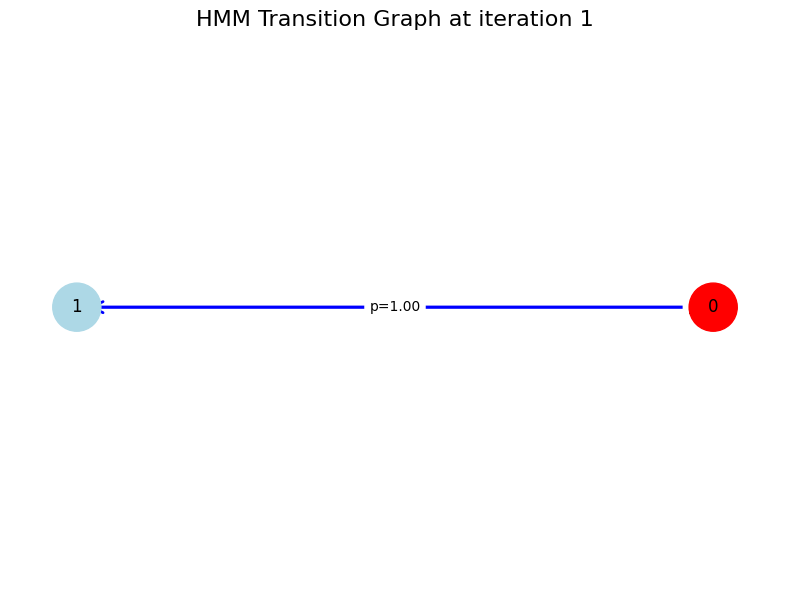

In [8]:
# Assume you've already fit your model and have 'best_model'
trans_mat = best_model.transmat_

# Plot it
plot_hmm_transition_graph(
    T=trans_mat,
    niter=1,             # or any iteration number
    highlight_node=0,    # e.g., highlight state 0
    highlight_node_2=2,  # highlight state 2
    threshold=0.05,      # omit edges with probability below 0.05
    save=True,
    savename='my_hmm_graph'
)
